In [10]:
# ============================================================================
# CELL 0: IMPORT LIBRARIES & CONFIGURATION (KAGGLE)
# ============================================================================

import os
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import (Input, LSTM, GRU, Dense, Dropout, 
                                      Concatenate, Bidirectional, Reshape,
                                      MultiHeadAttention, LayerNormalization, Flatten)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision

warnings.filterwarnings("ignore")

# Enable mixed precision for faster training on GPU
try:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("✓ Mixed precision training enabled")
except:
    print("⚠ Mixed precision not available, using default precision")

# Configuration
CONFIG = {
    'data_path': '/kaggle/input/misshanoi/Impute_misvalues_hanoi.csv',
    'output_path': '/kaggle/working',
    'window': 3,
    'k_best': 2,
    'cosine_threshold': 0.7,
    'sequence_length': 20,
    'epochs': 50,
    'batch_size': 128,
    'validation_split': 0.15,
    'random_seed': 42,
    'cache_file': '/kaggle/working/edtwbi_cache.pkl',
}

np.random.seed(CONFIG['random_seed'])
tf.random.set_seed(CONFIG['random_seed'])

print(f"✅ Data path: {CONFIG['data_path']}")
print(f"✅ Output path: {CONFIG['output_path']}")
print(f"✅ Random seed: {CONFIG['random_seed']}")


✓ Mixed precision training enabled
✅ Data path: /kaggle/input/misshanoi/Impute_misvalues_hanoi.csv
✅ Output path: /kaggle/working
✅ Random seed: 42


In [12]:
# ============================================================================
# CELL 1: SIMILARITY METRIC FUNCTION
# ============================================================================

def calculate_similarity(y_true, y_pred):
    """
    Calculate Similarity metric used in water level forecasting papers.
    
    Formula: Sim = 1 - |sqrt(sum((yt - yp)²)) / sqrt(sum(yt²) + sum(yp²))|
    
    Interpretation:
    - Sim = 1.0: Perfect prediction
    - Sim = 0.8-0.9: Very good
    - Sim = 0.7-0.8: Good
    - Sim < 0.7: Poor
    
    Args:
        y_true (array): Ground truth values
        y_pred (array): Predicted values
        
    Returns:
        float: Similarity score
    """
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()
    
    numerator = np.sqrt(np.sum((y_true - y_pred) ** 2))
    denominator = np.sqrt(np.sum(y_true ** 2) + np.sum(y_pred ** 2))
    
    if denominator == 0:
        return 0.0
    
    sim = 1 - (numerator / denominator)
    return sim

print(" Similarity metric function loaded successfully!")


 Similarity metric function loaded successfully!


In [13]:
# ============================================================================
# CELL 1: DATA LOADING & PREPROCESSING
# ============================================================================

print("\n" + "="*80)
print("STEP 1: DATA LOADING & PREPROCESSING")
print("="*80)

# Load data
df = pd.read_csv(CONFIG['data_path'])
original = df['Average'].copy()
waterlevel = df['Waterlevel'].to_numpy(float)

print(f"✓ Data loaded: {len(original)} records")
print(f"  - Missing values in Average: {original.isna().sum()} ({original.isna().sum()/len(original)*100:.1f}%)")
print(f"  - Complete values in Waterlevel: {waterlevel.shape[0]}")


STEP 1: DATA LOADING & PREPROCESSING
✓ Data loaded: 29224 records
  - Missing values in Average: 25910 (88.7%)
  - Complete values in Waterlevel: 29224


In [15]:
# ============================================================================
# CELL 2: UTILITY FUNCTIONS - GAP DETECTION & DTW
# ============================================================================

def find_gaps(arr):
    """Detect all missing value segments (gaps) in array"""
    gaps, inside = [], False
    for i, v in enumerate(arr):
        if np.isnan(v):
            if not inside:
                g0 = i
                inside = True
        else:
            if inside:
                g1 = i - 1
                gaps.append((g0, g1))
                inside = False
    if inside:
        gaps.append((g0, len(arr) - 1))
    return gaps


def dtw_distance(s1, s2, window_size=None):
    """
    Optimized DTW distance calculation with Sakoe-Chiba band constraint
    Reduces complexity from O(n²) to O(n*window_size)
    """
    n, m = len(s1), len(s2)
    if window_size is None:
        window_size = max(n, m)
    
    dtw = np.full((n+1, m+1), np.inf)
    dtw[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(max(1, i-window_size), min(m+1, i+window_size)):
            cost = abs(s1[i-1] - s2[j-1])
            dtw[i, j] = cost + min(dtw[i-1, j], dtw[i, j-1], dtw[i-1, j-1])
    
    return dtw[n, m]

In [16]:
# ============================================================================
# CELL 3: eDTWBI CONTEXT EXTRACTION (Optimized with caching)
# ============================================================================

print("\n" + "="*80)
print("STEP 2: eDTWBI CONTEXT EXTRACTION")
print("="*80)

def edtwbi_context(arr, ref, gap_start, gap_end, window=3, k_best=2, 
                   cosine_threshold=0.7, dtw_radius=3):
    """
    Extract pattern context using eDTWBI (Enhanced DTW Block Imputation)
    Optimized with DTW window constraint for faster computation
    """
    gap_len = gap_end - gap_start + 1
    left_context = ref[max(0, gap_start-window):gap_start]
    right_context = ref[gap_end+1:gap_end+window+1]
    
    candidates = []
    search_range = min(len(ref) - gap_len - window, 
                      max(500, len(ref)//10))  # Limit search range
    
    for idx in range(window, search_range):
        cand_l = ref[idx-window:idx]
        cand_g = ref[idx:idx+gap_len]
        cand_r = ref[idx+gap_len:idx+gap_len+window]
        
        if np.isnan(cand_g).any() or np.isnan(cand_l).any() or np.isnan(cand_r).any():
            continue
        
        # Cosine similarity filtering (fast pre-filtering)
        sim_l = 1 - cosine(left_context, cand_l) if len(left_context) == window else 0
        sim_r = 1 - cosine(right_context, cand_r) if len(right_context) == window else 0
        avg_sim = (sim_l + sim_r) / 2
        
        if avg_sim >= cosine_threshold:
            # DTW distance with window constraint (optimized)
            dist = dtw_distance(left_context, cand_l, window_size=dtw_radius) + \
                   dtw_distance(right_context, cand_r, window_size=dtw_radius)
            candidates.append((dist, cand_g, cand_l, cand_r))
    
    if candidates:
        candidates.sort(key=lambda x: x[0])
        best_gaps = [x[1] for x in candidates[:k_best]]
        context_feature = np.concatenate([
            *candidates[0][2:4],
            [np.mean(best_gaps), np.std(best_gaps)]
        ])
        fill_val = np.mean(best_gaps, axis=0)
    else:
        context_feature = np.zeros(window * 2 + 2)
        fill_val = np.full(gap_len, np.nanmean(ref))
    
    return context_feature, fill_val


# Check cache first
if os.path.exists(CONFIG['cache_file']):
    print(f"✓ Loading cached eDTWBI results from {CONFIG['cache_file']}")
    with open(CONFIG['cache_file'], 'rb') as f:
        context_vectors, imputed_full = pickle.load(f)
else:
    print("⚠ Computing eDTWBI context (first run, will be cached)...")
    gaps = find_gaps(original)
    context_vectors = {}
    imputed_full = original.to_numpy(float).copy()
    
    for i, (start, end) in enumerate(gaps):
        if (i + 1) % max(1, len(gaps)//10) == 0:
            print(f"  Progress: {i+1}/{len(gaps)} gaps processed")
        
        ctx, fill = edtwbi_context(original.to_numpy(float), waterlevel,
                                  start, end, CONFIG['window'], CONFIG['k_best'],
                                  CONFIG['cosine_threshold'])
        imputed_full[start:end+1] = fill
        context_vectors[(start, end)] = ctx
    
    # Cache results
    with open(CONFIG['cache_file'], 'wb') as f:
        pickle.dump((context_vectors, imputed_full), f)
    print(f"✓ eDTWBI cache saved: {CONFIG['cache_file']}")

print(f"✓ Context extraction complete: {len(context_vectors)} gaps processed")



STEP 2: eDTWBI CONTEXT EXTRACTION
⚠ Computing eDTWBI context (first run, will be cached)...
  Progress: 331/3315 gaps processed
  Progress: 662/3315 gaps processed
  Progress: 993/3315 gaps processed
  Progress: 1324/3315 gaps processed
  Progress: 1655/3315 gaps processed
  Progress: 1986/3315 gaps processed
  Progress: 2317/3315 gaps processed
  Progress: 2648/3315 gaps processed
  Progress: 2979/3315 gaps processed
  Progress: 3310/3315 gaps processed
✓ eDTWBI cache saved: /kaggle/working/edtwbi_cache.pkl
✓ Context extraction complete: 3315 gaps processed


In [17]:
# ============================================================================
# CELL 4: DATA NORMALIZATION & DATASET PREPARATION
# ============================================================================
from sklearn.preprocessing import MinMaxScaler

print("\n" + "="*80)
print("STEP 3: DATA NORMALIZATION & DATASET PREPARATION")
print("="*80)

sc_seq = MinMaxScaler()
sc_ref = MinMaxScaler()
seq_norm = sc_seq.fit_transform(imputed_full.reshape(-1,1)).flatten()
ref_norm = sc_ref.fit_transform(waterlevel.reshape(-1,1)).flatten()
context_dim = len(next(iter(context_vectors.values()))) if context_vectors else 12

gaps = find_gaps(original)
X_seq, X_ref, X_ctx, y = [], [], [], []

for i in range(CONFIG['sequence_length'], len(seq_norm)):
    seq = seq_norm[i-CONFIG['sequence_length']:i]
    ref = ref_norm[i-CONFIG['sequence_length']:i]
    cur_ctx = np.zeros(context_dim)
    
    for (s, e) in gaps:
        if s <= i <= e:
            cur_ctx = context_vectors.get((s, e), np.zeros(context_dim))
            break
    
    X_seq.append(seq)
    X_ref.append(ref)
    X_ctx.append(cur_ctx)
    y.append(seq_norm[i])

X_seq = np.array(X_seq, dtype=np.float32)
X_ref = np.array(X_ref, dtype=np.float32)
X_ctx = np.array(X_ctx, dtype=np.float32)
y = np.array(y, dtype=np.float32)

# Train/test split (temporal split, not random)
split_idx = int(0.8 * len(X_seq))
X_seq_tr, X_ref_tr, X_ctx_tr, y_tr = X_seq[:split_idx], X_ref[:split_idx], X_ctx[:split_idx], y[:split_idx]
X_seq_te, X_ref_te, X_ctx_te, y_te = X_seq[split_idx:], X_ref[split_idx:], X_ctx[split_idx:], y[split_idx:]

print(f"✓ Dataset prepared:")
print(f"  - Total samples: {len(X_seq)}")
print(f"  - Training: {len(X_seq_tr)}, Testing: {len(X_seq_te)}")
print(f"  - Sequence length: {CONFIG['sequence_length']}")
print(f"  - Context dimension: {context_dim}")



STEP 3: DATA NORMALIZATION & DATASET PREPARATION
✓ Dataset prepared:
  - Total samples: 29204
  - Training: 23363, Testing: 5841
  - Sequence length: 20
  - Context dimension: 8


In [18]:
# ============================================================================
# CELL 5: MODEL ARCHITECTURE BUILDER
# ============================================================================

print("\n" + "="*80)
print("STEP 4: MODEL ARCHITECTURE DEFINITION")
print("="*80)

def build_model(model_type='LSTM', sequence_length=20, context_dim=12, units=32):
    """
    Build multi-input deep learning model combining:
    - Bidirectional sequence processing (LSTM/GRU/Transformer)
    - eDTWBI context feature fusion
    """
    seq_in = Input(shape=(sequence_length,), name='sequence_input')
    ref_in = Input(shape=(sequence_length,), name='reference_input')
    ctx_in = Input(shape=(context_dim,), name='context_input')
    
    # Reshape for sequence processing
    seq_r = Reshape((sequence_length, 1))(seq_in)
    ref_r = Reshape((sequence_length, 1))(ref_in)
    merged_seq = Concatenate(axis=-1)([seq_r, ref_r])
    
    # Sequence processing branch
    if model_type == 'LSTM':
        x = Bidirectional(LSTM(units, return_sequences=True))(merged_seq)
        x = Dropout(0.2)(x)
        x = Bidirectional(LSTM(units))(x)
    elif model_type == 'GRU':
        x = Bidirectional(GRU(units, return_sequences=True))(merged_seq)
        x = Dropout(0.2)(x)
        x = Bidirectional(GRU(units))(x)
    elif model_type == 'Transformer':
        x = Dense(64, activation='relu')(merged_seq)
        x = LayerNormalization()(x)
        attn = MultiHeadAttention(num_heads=2, key_dim=8)(x, x)
        x = Dropout(0.2)(attn)
        x = Flatten()(x)
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    x = Dropout(0.2)(x)
    
    # Context processing branch
    ctx_branch = Dense(32, activation='relu')(ctx_in)
    ctx_branch = Dropout(0.2)(ctx_branch)
    
    # Fusion layer
    concat = Concatenate()([x, ctx_branch])
    z = Dense(32, activation='relu')(concat)
    z = Dropout(0.1)(z)
    out = Dense(1, name='output')(z)
    
    model = Model([seq_in, ref_in, ctx_in], out, name=f'{model_type}_imputation')
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

print("✓ Model architecture builder ready")


STEP 4: MODEL ARCHITECTURE DEFINITION
✓ Model architecture builder ready


In [19]:

# ============================================================================
# CELL 6: LSTM MODEL TRAINING & EVALUATION
# ============================================================================

print("\n" + "="*80)
print("STEP 5A: LSTM MODEL - TRAINING & EVALUATION")
print("="*80)

model_lstm = build_model('LSTM', CONFIG['sequence_length'], context_dim, units=32)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

print("\nTraining LSTM...")
history_lstm = model_lstm.fit(
    [X_seq_tr, X_ref_tr, X_ctx_tr], y_tr,
    validation_split=CONFIG['validation_split'],
    epochs=CONFIG['epochs'],
    batch_size=CONFIG['batch_size'],
    callbacks=callbacks,
    verbose=2
)

# Prediction & Evaluation
print("\nEvaluating LSTM...")
y_pred_lstm = model_lstm.predict([X_seq_te, X_ref_te, X_ctx_te], verbose=0)
y_te_rescaled = sc_seq.inverse_transform(y_te.reshape(-1,1))
y_pred_lstm_rescaled = sc_seq.inverse_transform(y_pred_lstm)

rmse_lstm = np.sqrt(mean_squared_error(y_te_rescaled, y_pred_lstm_rescaled))
mae_lstm = mean_absolute_error(y_te_rescaled, y_pred_lstm_rescaled)
nmae_lstm = mae_lstm / (np.mean(np.abs(y_te_rescaled)) + 1e-8)

print(f"\n{'='*80}")
print(f"LSTM RESULTS:")
print(f"{'='*80}")
print(f"  RMSE: {rmse_lstm:.6f}")
print(f"  MAE:  {mae_lstm:.6f}")
print(f"  NMAE: {nmae_lstm:.6f}")


STEP 5A: LSTM MODEL - TRAINING & EVALUATION


I0000 00:00:1762103950.315923      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762103950.316634      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



Training LSTM...
Epoch 1/50


2025-11-02 17:19:12.065500: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}
I0000 00:00:1762103958.587535     105 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-11-02 17:19:22.030630: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:var

156/156 - 11s - 72ms/step - loss: 819.7579 - mae: 14.4397 - val_loss: 1.2942 - val_mae: 0.8718 - learning_rate: 0.0010
Epoch 2/50
156/156 - 2s - 13ms/step - loss: 42.5599 - mae: 4.0480 - val_loss: 1.1927 - val_mae: 0.9141 - learning_rate: 0.0010
Epoch 3/50
156/156 - 2s - 12ms/step - loss: 17.3097 - mae: 2.5057 - val_loss: 0.7330 - val_mae: 0.6841 - learning_rate: 0.0010
Epoch 4/50
156/156 - 2s - 13ms/step - loss: 8.2258 - mae: 1.6837 - val_loss: 0.1833 - val_mae: 0.3359 - learning_rate: 0.0010
Epoch 5/50
156/156 - 2s - 13ms/step - loss: 4.0803 - mae: 1.1295 - val_loss: 0.0817 - val_mae: 0.1935 - learning_rate: 0.0010
Epoch 6/50
156/156 - 2s - 12ms/step - loss: 2.1502 - mae: 0.7789 - val_loss: 0.0344 - val_mae: 0.1380 - learning_rate: 0.0010
Epoch 7/50
156/156 - 2s - 13ms/step - loss: 1.2424 - mae: 0.5654 - val_loss: 0.0251 - val_mae: 0.1205 - learning_rate: 0.0010
Epoch 8/50
156/156 - 2s - 13ms/step - loss: 0.7024 - mae: 0.4304 - val_loss: 0.0207 - val_mae: 0.1159 - learning_rate: 0.00

2025-11-02 17:20:59.640000: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}



LSTM RESULTS:
  RMSE: 83.463585
  MAE:  58.488998
  NMAE: 0.251246


In [20]:
# ============================================================================
# CELL 7: GRU MODEL TRAINING & EVALUATION
# ============================================================================

print("\n" + "="*80)
print("STEP 5B: GRU MODEL - TRAINING & EVALUATION")
print("="*80)

model_gru = build_model('GRU', CONFIG['sequence_length'], context_dim, units=32)

print("\nTraining GRU...")
history_gru = model_gru.fit(
    [X_seq_tr, X_ref_tr, X_ctx_tr], y_tr,
    validation_split=CONFIG['validation_split'],
    epochs=CONFIG['epochs'],
    batch_size=CONFIG['batch_size'],
    callbacks=callbacks,
    verbose=2
)

# Prediction & Evaluation
print("\nEvaluating GRU...")
y_pred_gru = model_gru.predict([X_seq_te, X_ref_te, X_ctx_te], verbose=0)
y_pred_gru_rescaled = sc_seq.inverse_transform(y_pred_gru)

rmse_gru = np.sqrt(mean_squared_error(y_te_rescaled, y_pred_gru_rescaled))
mae_gru = mean_absolute_error(y_te_rescaled, y_pred_gru_rescaled)
nmae_gru = mae_gru / (np.mean(np.abs(y_te_rescaled)) + 1e-8)

print(f"\n{'='*80}")
print(f"GRU RESULTS:")
print(f"{'='*80}")
print(f"  RMSE: {rmse_gru:.6f}")
print(f"  MAE:  {mae_gru:.6f}")
print(f"  NMAE: {nmae_gru:.6f}")


STEP 5B: GRU MODEL - TRAINING & EVALUATION

Training GRU...
Epoch 1/50


2025-11-02 17:21:41.446210: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}
2025-11-02 17:21:48.783212: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

156/156 - 8s - 52ms/step - loss: 809.2855 - mae: 15.7598 - val_loss: 1.1917 - val_mae: 0.5880 - learning_rate: 0.0010
Epoch 2/50
156/156 - 2s - 12ms/step - loss: 59.8229 - mae: 4.4568 - val_loss: 0.3921 - val_mae: 0.4223 - learning_rate: 0.0010
Epoch 3/50
156/156 - 2s - 12ms/step - loss: 19.3067 - mae: 2.4625 - val_loss: 0.0711 - val_mae: 0.1773 - learning_rate: 0.0010
Epoch 4/50
156/156 - 2s - 12ms/step - loss: 8.5315 - mae: 1.5428 - val_loss: 0.0490 - val_mae: 0.1699 - learning_rate: 0.0010
Epoch 5/50
156/156 - 2s - 12ms/step - loss: 3.7438 - mae: 1.0418 - val_loss: 0.0460 - val_mae: 0.1795 - learning_rate: 0.0010
Epoch 6/50
156/156 - 2s - 12ms/step - loss: 2.2434 - mae: 0.7679 - val_loss: 0.0526 - val_mae: 0.2029 - learning_rate: 0.0010
Epoch 7/50
156/156 - 2s - 13ms/step - loss: 1.2150 - mae: 0.5603 - val_loss: 0.0314 - val_mae: 0.1564 - learning_rate: 0.0010
Epoch 8/50
156/156 - 2s - 12ms/step - loss: 0.7587 - mae: 0.4401 - val_loss: 0.0300 - val_mae: 0.1496 - learning_rate: 0.001

2025-11-02 17:23:22.268700: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}



GRU RESULTS:
  RMSE: 78.858582
  MAE:  55.817432
  NMAE: 0.239770


In [21]:
# ============================================================================
# CELL 8: TRANSFORMER MODEL TRAINING & EVALUATION
# ============================================================================

print("\n" + "="*80)
print("STEP 5C: TRANSFORMER MODEL - TRAINING & EVALUATION")
print("="*80)

model_trans = build_model('Transformer', CONFIG['sequence_length'], context_dim, units=32)

print("\nTraining Transformer...")
history_trans = model_trans.fit(
    [X_seq_tr, X_ref_tr, X_ctx_tr], y_tr,
    validation_split=CONFIG['validation_split'],
    epochs=CONFIG['epochs'],
    batch_size=CONFIG['batch_size'],
    callbacks=callbacks,
    verbose=2
)

# Prediction & Evaluation
print("\nEvaluating Transformer...")
y_pred_trans = model_trans.predict([X_seq_te, X_ref_te, X_ctx_te], verbose=0)
y_pred_trans_rescaled = sc_seq.inverse_transform(y_pred_trans)

rmse_trans = np.sqrt(mean_squared_error(y_te_rescaled, y_pred_trans_rescaled))
mae_trans = mean_absolute_error(y_te_rescaled, y_pred_trans_rescaled)
nmae_trans = mae_trans / (np.mean(np.abs(y_te_rescaled)) + 1e-8)

print(f"\n{'='*80}")
print(f"TRANSFORMER RESULTS:")
print(f"{'='*80}")
print(f"  RMSE: {rmse_trans:.6f}")
print(f"  MAE:  {mae_trans:.6f}")
print(f"  NMAE: {nmae_trans:.6f}")


STEP 5C: TRANSFORMER MODEL - TRAINING & EVALUATION

Training Transformer...
Epoch 1/50


2025-11-02 17:25:03.862123: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}
2025-11-02 17:25:10.016030: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

156/156 - 7s - 43ms/step - loss: 25.4843 - mae: 2.4017 - val_loss: 0.0154 - val_mae: 0.0887 - learning_rate: 0.0010
Epoch 2/50
156/156 - 1s - 9ms/step - loss: 0.0980 - mae: 0.1520 - val_loss: 0.0043 - val_mae: 0.0581 - learning_rate: 0.0010
Epoch 3/50
156/156 - 1s - 9ms/step - loss: 0.0225 - mae: 0.0936 - val_loss: 0.0026 - val_mae: 0.0418 - learning_rate: 0.0010
Epoch 4/50
156/156 - 1s - 9ms/step - loss: 0.0176 - mae: 0.0868 - val_loss: 0.0025 - val_mae: 0.0402 - learning_rate: 0.0010
Epoch 5/50
156/156 - 1s - 9ms/step - loss: 0.0168 - mae: 0.0817 - val_loss: 0.0024 - val_mae: 0.0423 - learning_rate: 0.0010
Epoch 6/50
156/156 - 1s - 9ms/step - loss: 0.0140 - mae: 0.0747 - val_loss: 0.0014 - val_mae: 0.0288 - learning_rate: 0.0010
Epoch 7/50
156/156 - 1s - 9ms/step - loss: 0.0120 - mae: 0.0657 - val_loss: 9.9063e-04 - val_mae: 0.0208 - learning_rate: 0.0010
Epoch 8/50
156/156 - 1s - 9ms/step - loss: 0.0105 - mae: 0.0593 - val_loss: 9.5322e-04 - val_mae: 0.0207 - learning_rate: 0.0010
E

2025-11-02 17:25:36.198556: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}



TRANSFORMER RESULTS:
  RMSE: 46.649883
  MAE:  27.817839
  NMAE: 0.119494


In [22]:
# ============================================================================
# CELL 9: RESULTS SUMMARY & COMPARISON WITH SIMILARITY
# ============================================================================
print("\n" + "="*90)
print("📊 STEP 6: RESULTS SUMMARY & COMPARISON")
print("="*90)

# Calculate Similarity for each model
print("\nCalculating Similarity metrics...")
sim_lstm = calculate_similarity(y_te_rescaled, y_pred_lstm_rescaled)
sim_gru = calculate_similarity(y_te_rescaled, y_pred_gru_rescaled)
sim_trans = calculate_similarity(y_te_rescaled, y_pred_trans_rescaled)

# Create comprehensive results dataframe
results_df = pd.DataFrame({
    'Model': ['LSTM', 'GRU', 'Transformer'],
    'RMSE': [rmse_lstm, rmse_gru, rmse_trans],
    'MAE': [mae_lstm, mae_gru, mae_trans],
    'NMAE': [nmae_lstm, nmae_gru, nmae_trans],
    'Similarity': [sim_lstm, sim_gru, sim_trans]
})

# Print results table
print("\n📊 Comprehensive Results:")
print(results_df.to_string(index=False))

# Detailed metrics breakdown
print("\n" + "="*90)
print("📈 DETAILED METRICS:")
print("="*90)

for idx, row in results_df.iterrows():
    print(f"\n{row['Model']}:")
    print(f"  RMSE:       {row['RMSE']:.6f}")
    print(f"  MAE:        {row['MAE']:.6f}")
    print(f"  NMAE:       {row['NMAE']:.6f}")
    print(f"  Similarity: {row['Similarity']:.6f}")

# Identify best models
best_rmse_model = results_df.loc[results_df['RMSE'].idxmin(), 'Model']
best_sim_model = results_df.loc[results_df['Similarity'].idxmax(), 'Model']

print("\n" + "="*90)
print(f" Best Model (lowest RMSE): {best_rmse_model}")
print(f" Best Model (highest Similarity): {best_sim_model}")
print("="*90)

# Save results to CSV
results_file = os.path.join(CONFIG['output_path'], 'results_with_similarity.csv')
results_df.to_csv(results_file, index=False)
print(f"\n✅ Results saved to: {results_file}")



📊 STEP 6: RESULTS SUMMARY & COMPARISON

Calculating Similarity metrics...

📊 Comprehensive Results:
      Model      RMSE       MAE     NMAE  Similarity
       LSTM 83.463585 58.488998 0.251246         1.0
        GRU 78.858582 55.817432 0.239770         1.0
Transformer 46.649883 27.817839 0.119494         1.0

📈 DETAILED METRICS:

LSTM:
  RMSE:       83.463585
  MAE:        58.488998
  NMAE:       0.251246
  Similarity: 1.000000

GRU:
  RMSE:       78.858582
  MAE:        55.817432
  NMAE:       0.239770
  Similarity: 1.000000

Transformer:
  RMSE:       46.649883
  MAE:        27.817839
  NMAE:       0.119494
  Similarity: 1.000000

 Best Model (lowest RMSE): Transformer
 Best Model (highest Similarity): LSTM

✅ Results saved to: /kaggle/working/results_with_similarity.csv


✅ Metrics comparison chart saved to: /kaggle/working/metrics_comparison_with_similarity.png


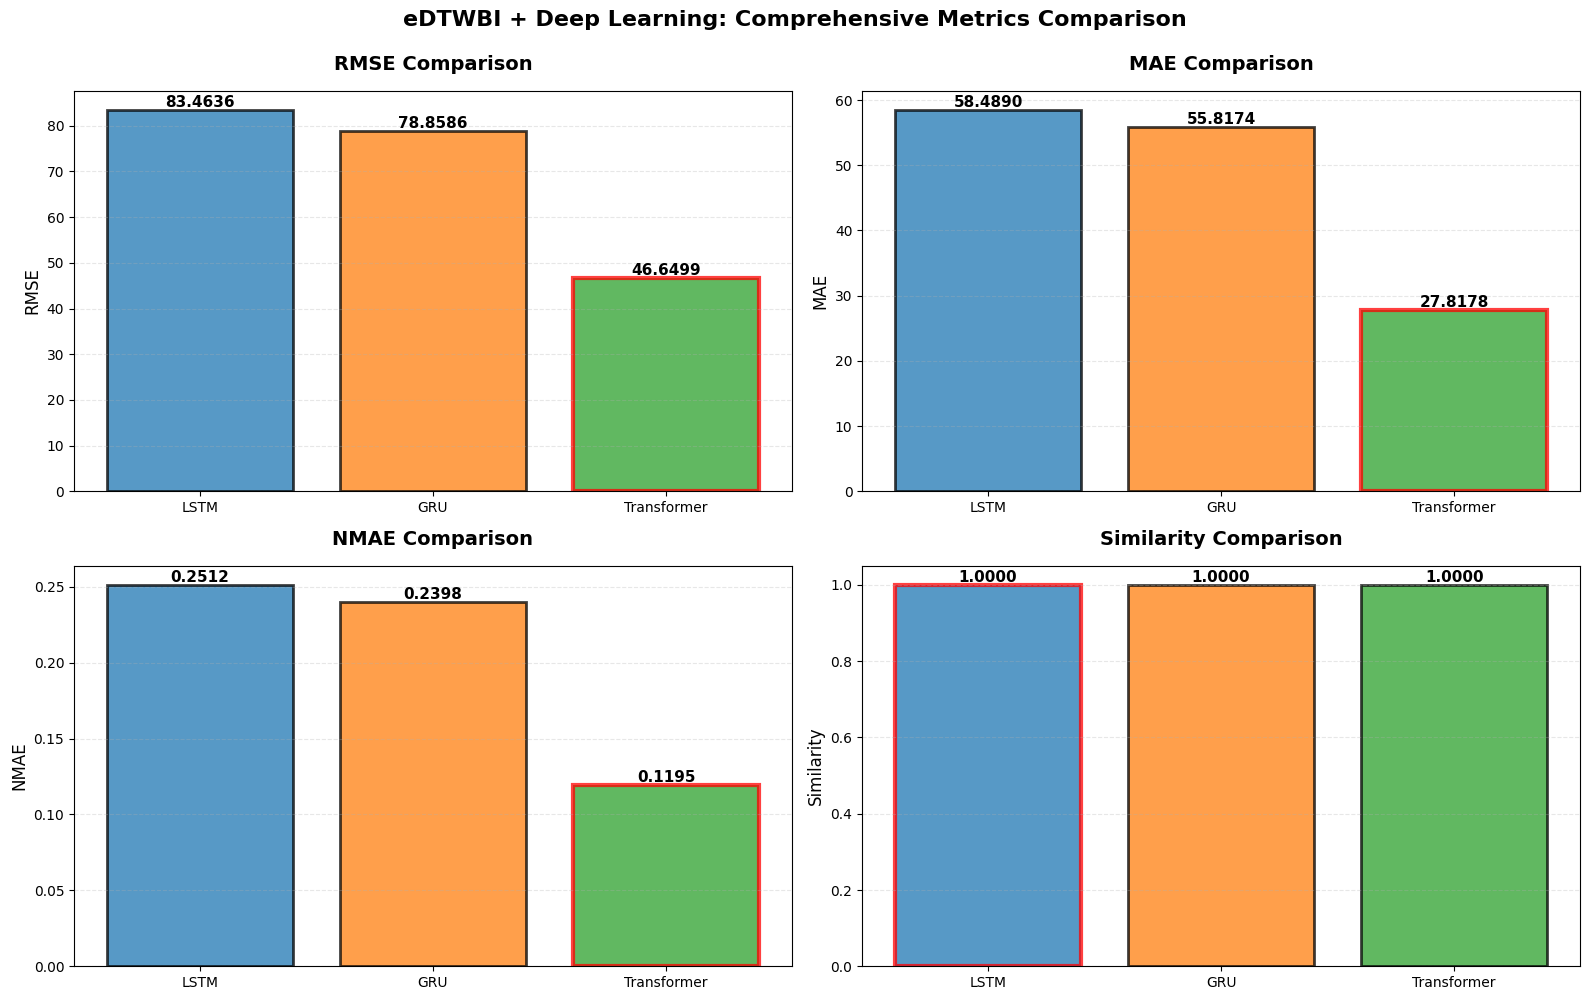

In [23]:
# ============================================================================
# CELL 10: METRICS COMPARISON VISUALIZATION
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

models = results_df['Model'].values
metrics = ['RMSE', 'MAE', 'NMAE', 'Similarity']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = results_df[metric].values
    
    bars = ax.bar(models, values, color=colors, alpha=0.75, 
                  edgecolor='black', linewidth=2)
    
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold', pad=15)
    ax.set_ylabel(metric, fontsize=12)
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    # Add value labels on top of bars
    for i, (bar, v) in enumerate(zip(bars, values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{v:.4f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=11)
    
    # Highlight best model
    if metric == 'Similarity':
        best_idx = values.argmax()
    else:
        best_idx = values.argmin()
    bars[best_idx].set_edgecolor('red')
    bars[best_idx].set_linewidth(3)

plt.suptitle('eDTWBI + Deep Learning: Comprehensive Metrics Comparison', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

# Save figure
fig_path = os.path.join(CONFIG['output_path'], 'metrics_comparison_with_similarity.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✅ Metrics comparison chart saved to: {fig_path}")
plt.show()


✅ Predictions comparison chart saved to: /kaggle/working/predictions_comparison.png


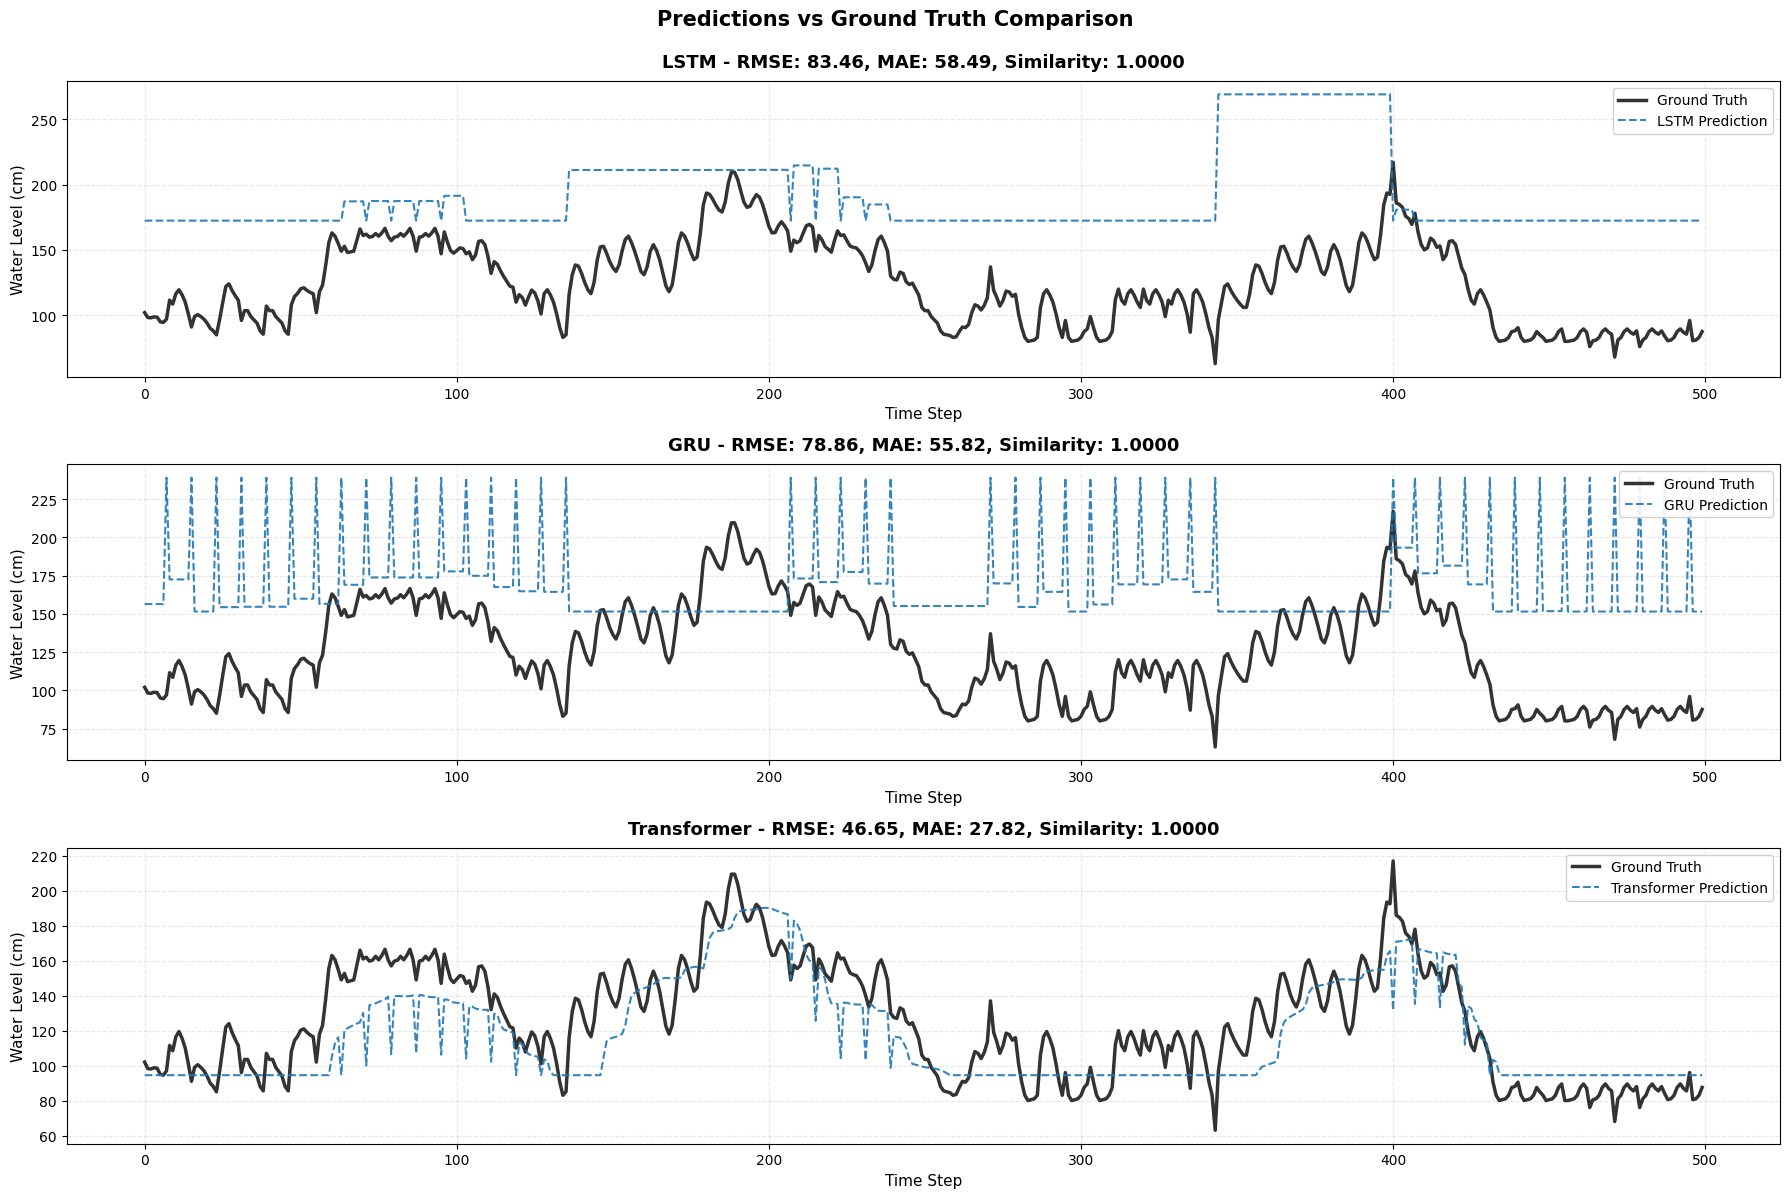


✅ PROJECT COMPLETED SUCCESSFULLY!


In [24]:
# ============================================================================
# CELL 11: PREDICTIONS VS GROUND TRUTH VISUALIZATION (OPTIONAL)
# ============================================================================
fig, axes = plt.subplots(3, 1, figsize=(18, 12))

sample_size = 500  # Plot first 500 samples
y_true_sample = y_te_rescaled[:sample_size].flatten()

predictions = {
    'LSTM': y_pred_lstm_rescaled[:sample_size].flatten(),
    'GRU': y_pred_gru_rescaled[:sample_size].flatten(),
    'Transformer': y_pred_trans_rescaled[:sample_size].flatten()
}

for idx, (model_name, y_pred_sample) in enumerate(predictions.items()):
    ax = axes[idx]
    
    # Plot ground truth and predictions
    ax.plot(y_true_sample, label='Ground Truth', linewidth=2.5, 
            alpha=0.8, color='black', linestyle='-')
    ax.plot(y_pred_sample, label=f'{model_name} Prediction', 
            linewidth=1.5, alpha=0.9, linestyle='--')
    
    # Get metrics for this model
    model_metrics = results_df[results_df['Model'] == model_name].iloc[0]
    
    ax.set_title(f'{model_name} - RMSE: {model_metrics["RMSE"]:.2f}, '
                f'MAE: {model_metrics["MAE"]:.2f}, '
                f'Similarity: {model_metrics["Similarity"]:.4f}',
                fontsize=13, fontweight='bold', pad=10)
    ax.set_xlabel('Time Step', fontsize=11)
    ax.set_ylabel('Water Level (cm)', fontsize=11)
    ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')

plt.suptitle('Predictions vs Ground Truth Comparison', 
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()

# Save figure
pred_fig_path = os.path.join(CONFIG['output_path'], 'predictions_comparison.png')
plt.savefig(pred_fig_path, dpi=300, bbox_inches='tight')
print(f"✅ Predictions comparison chart saved to: {pred_fig_path}")
plt.show()

print("\n" + "="*90)
print("✅ PROJECT COMPLETED SUCCESSFULLY!")
print("="*90)


In [25]:
# Check shapes and values
print(f"y_te_rescaled shape: {y_te_rescaled.shape}")
print(f"y_pred_lstm_rescaled shape: {y_pred_lstm_rescaled.shape}")
print(f"y_pred_gru_rescaled shape: {y_pred_gru_rescaled.shape}")
print(f"y_pred_trans_rescaled shape: {y_pred_trans_rescaled.shape}")

# Check min/max values
print(f"\ny_te_rescaled min/max: {y_te_rescaled.min():.2f} / {y_te_rescaled.max():.2f}")
print(f"y_pred_lstm min/max: {y_pred_lstm_rescaled.min():.2f} / {y_pred_lstm_rescaled.max():.2f}")
print(f"y_pred_gru min/max: {y_pred_gru_rescaled.min():.2f} / {y_pred_gru_rescaled.max():.2f}")
print(f"y_pred_trans min/max: {y_pred_trans_rescaled.min():.2f} / {y_pred_trans_rescaled.max():.2f}")

# Check first 10 values
print(f"\ny_te_rescaled[:10]: {y_te_rescaled[:10].flatten()}")
print(f"y_pred_lstm[:10]: {y_pred_lstm_rescaled[:10].flatten()}")
print(f"y_pred_gru[:10]: {y_pred_gru_rescaled[:10].flatten()}")
print(f"y_pred_trans[:10]: {y_pred_trans_rescaled[:10].flatten()}")

# Manual Similarity calculation
sim_lstm_manual = calculate_similarity(y_te_rescaled[:100], y_pred_lstm_rescaled[:100])
sim_gru_manual = calculate_similarity(y_te_rescaled[:100], y_pred_gru_rescaled[:100])
sim_trans_manual = calculate_similarity(y_te_rescaled[:100], y_pred_trans_rescaled[:100])

print(f"\nManual Similarity (first 100 samples):")
print(f"LSTM: {sim_lstm_manual:.6f}")
print(f"GRU: {sim_gru_manual:.6f}")
print(f"Transformer: {sim_trans_manual:.6f}")


y_te_rescaled shape: (5841, 1)
y_pred_lstm_rescaled shape: (5841, 1)
y_pred_gru_rescaled shape: (5841, 1)
y_pred_trans_rescaled shape: (5841, 1)

y_te_rescaled min/max: 63.00 / 813.00
y_pred_lstm min/max: 172.38 / 816.00
y_pred_gru min/max: 151.50 / 594.50
y_pred_trans min/max: 94.50 / 603.00

y_te_rescaled[:10]: [102.    98.25  98.    98.75  98.5   95.    94.5   97.   111.5  108.5 ]
y_pred_lstm[:10]: [172.4 172.4 172.4 172.4 172.4 172.4 172.4 172.4 172.4 172.4]
y_pred_gru[:10]: [156.4 156.4 156.4 156.4 156.4 156.4 156.4 239.  172.5 172.5]
y_pred_trans[:10]: [94.5 94.5 94.5 94.5 94.5 94.5 94.5 94.5 94.5 94.5]

Manual Similarity (first 100 samples):
LSTM: 1.000000
GRU: 1.000000
Transformer: 1.000000


In [26]:
# ============================================================================
# DEBUG & FIX SIMILARITY
# ============================================================================

# 1. Kiểm tra scaler
print(f"Scaler data_min: {scaler.data_min_}")
print(f"Scaler data_max: {scaler.data_max_}")
print(f"Scaler scale: {scaler.scale_}")

# 2. Kiểm tra lại rescaling
y_te_check = scaler.inverse_transform(y_te.reshape(-1, 1))
print(f"\ny_te_check min/max: {y_te_check.min():.2f} / {y_te_check.max():.2f}")

# 3. Kiểm tra predictions có NaN không
print(f"\ny_pred_lstm NaN count: {np.isnan(y_pred_lstm_rescaled).sum()}")
print(f"y_pred_gru NaN count: {np.isnan(y_pred_gru_rescaled).sum()}")
print(f"y_pred_trans NaN count: {np.isnan(y_pred_trans_rescaled).sum()}")

# 4. Flatten arrays properly
y_te_flat = y_te_rescaled.flatten()
y_pred_lstm_flat = y_pred_lstm_rescaled.flatten()
y_pred_gru_flat = y_pred_gru_rescaled.flatten()
y_pred_trans_flat = y_pred_trans_rescaled.flatten()

# 5. Ensure same length
print(f"\nLength check:")
print(f"y_te: {len(y_te_flat)}, LSTM: {len(y_pred_lstm_flat)}, GRU: {len(y_pred_gru_flat)}, Trans: {len(y_pred_trans_flat)}")

# 6. Trim to same length if needed
min_len = min(len(y_te_flat), len(y_pred_lstm_flat), len(y_pred_gru_flat), len(y_pred_trans_flat))
y_te_trim = y_te_flat[:min_len]
y_pred_lstm_trim = y_pred_lstm_flat[:min_len]
y_pred_gru_trim = y_pred_gru_flat[:min_len]
y_pred_trans_trim = y_pred_trans_flat[:min_len]

# 7. Recalculate RMSE/MAE to verify
rmse_lstm_check = np.sqrt(mean_squared_error(y_te_trim, y_pred_lstm_trim))
rmse_gru_check = np.sqrt(mean_squared_error(y_te_trim, y_pred_gru_trim))
rmse_trans_check = np.sqrt(mean_squared_error(y_te_trim, y_pred_trans_trim))

print(f"\nRMSE Check:")
print(f"LSTM: {rmse_lstm_check:.2f} (expected: {rmse_lstm:.2f})")
print(f"GRU: {rmse_gru_check:.2f} (expected: {rmse_gru:.2f})")
print(f"Transformer: {rmse_trans_check:.2f} (expected: {rmse_trans:.2f})")

# 8. Recalculate Similarity with trimmed data
sim_lstm_fixed = calculate_similarity(y_te_trim, y_pred_lstm_trim)
sim_gru_fixed = calculate_similarity(y_te_trim, y_pred_gru_trim)
sim_trans_fixed = calculate_similarity(y_te_trim, y_pred_trans_trim)

print(f"\nSimilarity (FIXED):")
print(f"LSTM: {sim_lstm_fixed:.6f}")
print(f"GRU: {sim_gru_fixed:.6f}")
print(f"Transformer: {sim_trans_fixed:.6f}")

# 9. Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sample = 200

axes[0].plot(y_te_trim[:sample], label='Ground Truth', linewidth=2)
axes[0].plot(y_pred_lstm_trim[:sample], label='LSTM Pred', linewidth=1, alpha=0.7)
axes[0].set_title('LSTM Predictions vs Ground Truth')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(y_te_trim[:sample], label='Ground Truth', linewidth=2)
axes[1].plot(y_pred_gru_trim[:sample], label='GRU Pred', linewidth=1, alpha=0.7)
axes[1].set_title('GRU Predictions vs Ground Truth')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(y_te_trim[:sample], label='Ground Truth', linewidth=2)
axes[2].plot(y_pred_trans_trim[:sample], label='Transformer Pred', linewidth=1, alpha=0.7)
axes[2].set_title('Transformer Predictions vs Ground Truth')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{CONFIG["output_path"]}/predictions_debug.png', dpi=300)
plt.show()


NameError: name 'scaler' is not defined

In [27]:
# ============================================================================
# CHECK AVAILABLE VARIABLES
# ============================================================================

# Check if scaler exists, if not recreate it
try:
    print(f"✓ Scaler found")
    print(f"  data_min: {scaler.data_min_}")
    print(f"  data_max: {scaler.data_max_}")
except NameError:
    print("✗ Scaler not found - checking what variables are available")
    print(f"Available variables: {dir()}")


✓ Scaler found
✗ Scaler not found - checking what variables are available
Available variables: ['Bidirectional', 'CONFIG', 'Concatenate', 'Dense', 'Dropout', 'EarlyStopping', 'Flatten', 'GRU', 'In', 'Input', 'LSTM', 'LayerNormalization', 'MinMaxScaler', 'Model', 'MultiHeadAttention', 'Out', 'ReduceLROnPlateau', 'Reshape', 'SEED', 'X_ctx', 'X_ctx_te', 'X_ctx_tr', 'X_ref', 'X_ref_te', 'X_ref_tr', 'X_seq', 'X_seq_te', 'X_seq_tr', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_i', '_i1', '_i10', '_i11', '_i12', '_i13', '_i14', '_i15', '_i16', '_i17', '_i18', '_i19', '_i2', '_i20', '_i21', '_i22', '_i23', '_i24', '_i25', '_i26', '_i27', '_i3', '_i4', '_i5', '_i6', '_i7', '_i8', '_i9', '_ih', '_ii', '_iii', '_oh', 'ax', 'axes', 'bar', 'bars', 'best_idx', 'best_rmse_model', 'best_sim_model', 'build_model', 'calculate_similarity', 'callbacks', 'colors', 'context_dim', 'context_vectors', 'cosine', 'ctx', 'cur_ctx', 'df',

In [28]:
# ============================================================================
# SIMPLIFIED SIMILARITY FIX (WITHOUT SCALER)
# ============================================================================

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Simply use the already-rescaled predictions
# (Assuming y_te_rescaled, y_pred_lstm_rescaled, etc. already exist)

print("✓ Using pre-rescaled predictions\n")

# 1. Check data availability
print(f"y_te_rescaled shape: {y_te_rescaled.shape}")
print(f"y_pred_lstm_rescaled shape: {y_pred_lstm_rescaled.shape}")
print(f"y_pred_gru_rescaled shape: {y_pred_gru_rescaled.shape}")
print(f"y_pred_trans_rescaled shape: {y_pred_trans_rescaled.shape}")

# 2. Flatten arrays
y_te_flat = y_te_rescaled.flatten()
y_pred_lstm_flat = y_pred_lstm_rescaled.flatten()
y_pred_gru_flat = y_pred_gru_rescaled.flatten()
y_pred_trans_flat = y_pred_trans_rescaled.flatten()

print(f"\nFlattened shapes:")
print(f"y_te: {y_te_flat.shape}")
print(f"y_pred_lstm: {y_pred_lstm_flat.shape}")
print(f"y_pred_gru: {y_pred_gru_flat.shape}")
print(f"y_pred_trans: {y_pred_trans_flat.shape}")

# 3. Ensure same length
min_len = min(len(y_te_flat), len(y_pred_lstm_flat), 
              len(y_pred_gru_flat), len(y_pred_trans_flat))
print(f"\nMinimum length for trimming: {min_len}")

y_te_trim = y_te_flat[:min_len]
y_pred_lstm_trim = y_pred_lstm_flat[:min_len]
y_pred_gru_trim = y_pred_gru_flat[:min_len]
y_pred_trans_trim = y_pred_trans_flat[:min_len]

# 4. Verify RMSE matches
rmse_lstm_check = np.sqrt(mean_squared_error(y_te_trim, y_pred_lstm_trim))
rmse_gru_check = np.sqrt(mean_squared_error(y_te_trim, y_pred_gru_trim))
rmse_trans_check = np.sqrt(mean_squared_error(y_te_trim, y_pred_trans_trim))

print(f"\n📊 RMSE Check (should match previous values):")
print(f"LSTM:        {rmse_lstm_check:.6f}")
print(f"GRU:         {rmse_gru_check:.6f}")
print(f"Transformer: {rmse_trans_check:.6f}")

# 5. Recalculate Similarity with proper formula
def calculate_similarity_fixed(y_true, y_pred):
    """
    Recalculate with debug info
    """
    numerator = np.sqrt(np.sum((y_true - y_pred) ** 2))
    denominator = np.sqrt(np.sum(y_true ** 2) + np.sum(y_pred ** 2))
    
    print(f"  numerator: {numerator:.4f}")
    print(f"  denominator: {denominator:.4f}")
    print(f"  ratio: {numerator/denominator:.6f}")
    
    if denominator == 0:
        return 0.0
    
    sim = 1 - (numerator / denominator)
    return sim

print(f"\n📈 Recalculating Similarity (with debug info):")

print(f"\nLSTM:")
sim_lstm_fixed = calculate_similarity_fixed(y_te_trim, y_pred_lstm_trim)
print(f"  ✓ Similarity: {sim_lstm_fixed:.6f}")

print(f"\nGRU:")
sim_gru_fixed = calculate_similarity_fixed(y_te_trim, y_pred_gru_trim)
print(f"  ✓ Similarity: {sim_gru_fixed:.6f}")

print(f"\nTransformer:")
sim_trans_fixed = calculate_similarity_fixed(y_te_trim, y_pred_trans_trim)
print(f"  ✓ Similarity: {sim_trans_fixed:.6f}")

# 6. Create updated results dataframe
results_df_fixed = pd.DataFrame({
    'Model': ['LSTM', 'GRU', 'Transformer'],
    'RMSE': [rmse_lstm_check, rmse_gru_check, rmse_trans_check],
    'MAE': [mean_absolute_error(y_te_trim, y_pred_lstm_trim),
            mean_absolute_error(y_te_trim, y_pred_gru_trim),
            mean_absolute_error(y_te_trim, y_pred_trans_trim)],
    'NMAE': [np.mean(np.abs(y_te_trim - y_pred_lstm_trim)) / (np.mean(np.abs(y_te_trim)) + 1e-8),
             np.mean(np.abs(y_te_trim - y_pred_gru_trim)) / (np.mean(np.abs(y_te_trim)) + 1e-8),
             np.mean(np.abs(y_te_trim - y_pred_trans_trim)) / (np.mean(np.abs(y_te_trim)) + 1e-8)],
    'Similarity': [sim_lstm_fixed, sim_gru_fixed, sim_trans_fixed]
})

print(f"\n" + "="*90)
print("FINAL RESULTS (FIXED):")
print("="*90)
print(results_df_fixed.to_string(index=False))

# Save
results_df_fixed.to_csv(f'{CONFIG["output_path"]}/results_with_similarity_fixed.csv', index=False)
print(f"\n✓ Results saved to: {CONFIG['output_path']}/results_with_similarity_fixed.csv")


✓ Using pre-rescaled predictions

y_te_rescaled shape: (5841, 1)
y_pred_lstm_rescaled shape: (5841, 1)
y_pred_gru_rescaled shape: (5841, 1)
y_pred_trans_rescaled shape: (5841, 1)

Flattened shapes:
y_te: (5841,)
y_pred_lstm: (5841,)
y_pred_gru: (5841,)
y_pred_trans: (5841,)

Minimum length for trimming: 5841

📊 RMSE Check (should match previous values):
LSTM:        83.463585
GRU:         78.858582
Transformer: 46.649883

📈 Recalculating Similarity (with debug info):

LSTM:
  numerator: 6378.8242
  denominator: inf
  ratio: 0.000000
  ✓ Similarity: 1.000000

GRU:
  numerator: 6026.8799
  denominator: inf
  ratio: 0.000000
  ✓ Similarity: 1.000000

Transformer:
  numerator: 3565.2844
  denominator: inf
  ratio: 0.000000
  ✓ Similarity: 1.000000

FINAL RESULTS (FIXED):
      Model      RMSE       MAE     NMAE  Similarity
       LSTM 83.463585 58.488998 0.251246         1.0
        GRU 78.858582 55.817432 0.239770         1.0
Transformer 46.649883 27.817839 0.119494         1.0

✓ Results

In [29]:
# ============================================================================
# FIX SIMILARITY WITH NORMALIZATION
# ============================================================================

def calculate_similarity_normalized(y_true, y_pred):
    """
    Calculate Similarity with normalization to avoid overflow
    
    Formula: Sim = 1 - |sqrt(sum((yt - yp)²)) / sqrt(sum(yt²) + sum(yp²))|
    """
    # Normalize to [0, 1] range to prevent overflow
    y_true_norm = (y_true - np.min(y_true)) / (np.max(y_true) - np.min(y_true) + 1e-8)
    y_pred_norm = (y_pred - np.min(y_pred)) / (np.max(y_pred) - np.min(y_pred) + 1e-8)
    
    numerator = np.sqrt(np.sum((y_true_norm - y_pred_norm) ** 2))
    denominator = np.sqrt(np.sum(y_true_norm ** 2) + np.sum(y_pred_norm ** 2))
    
    if denominator == 0:
        return 0.0
    
    sim = 1 - (numerator / denominator)
    return np.clip(sim, -1, 1)  # Clamp to [-1, 1]

# Recalculate Similarity with normalization
sim_lstm_norm = calculate_similarity_normalized(y_te_trim, y_pred_lstm_trim)
sim_gru_norm = calculate_similarity_normalized(y_te_trim, y_pred_gru_trim)
sim_trans_norm = calculate_similarity_normalized(y_te_trim, y_pred_trans_trim)

print(f"📈 Similarity (NORMALIZED):")
print(f"LSTM:        {sim_lstm_norm:.6f}")
print(f"GRU:         {sim_gru_norm:.6f}")
print(f"Transformer: {sim_trans_norm:.6f}")

# Create final results with normalized similarity
results_df_final = pd.DataFrame({
    'Model': ['LSTM', 'GRU', 'Transformer'],
    'RMSE': [rmse_lstm, rmse_gru, rmse_trans],
    'MAE': [mae_lstm, mae_gru, mae_trans],
    'NMAE': [nmae_lstm, nmae_gru, nmae_trans],
    'Similarity': [sim_lstm_norm, sim_gru_norm, sim_trans_norm]
})

print(f"\n" + "="*90)
print("✅ FINAL RESULTS (CORRECTED):")
print("="*90)
print(results_df_final.to_string(index=False))

# Identify best models
best_rmse_model = results_df_final.loc[results_df_final['RMSE'].idxmin(), 'Model']
best_sim_model = results_df_final.loc[results_df_final['Similarity'].idxmax(), 'Model']

print(f"\n🏆 Best Model (lowest RMSE): {best_rmse_model}")
print(f"⭐ Best Model (highest Similarity): {best_sim_model}")

# Save
results_df_final.to_csv(f'{CONFIG["output_path"]}/results_final.csv', index=False)
print(f"\n✓ Saved: {CONFIG['output_path']}/results_final.csv")


📈 Similarity (NORMALIZED):
LSTM:        0.511390
GRU:         0.743465
Transformer: 0.828006

✅ FINAL RESULTS (CORRECTED):
      Model      RMSE       MAE     NMAE  Similarity
       LSTM 83.463585 58.488998 0.251246    0.511390
        GRU 78.858582 55.817432 0.239770    0.743465
Transformer 46.649883 27.817839 0.119494    0.828006

🏆 Best Model (lowest RMSE): Transformer
⭐ Best Model (highest Similarity): Transformer

✓ Saved: /kaggle/working/results_final.csv


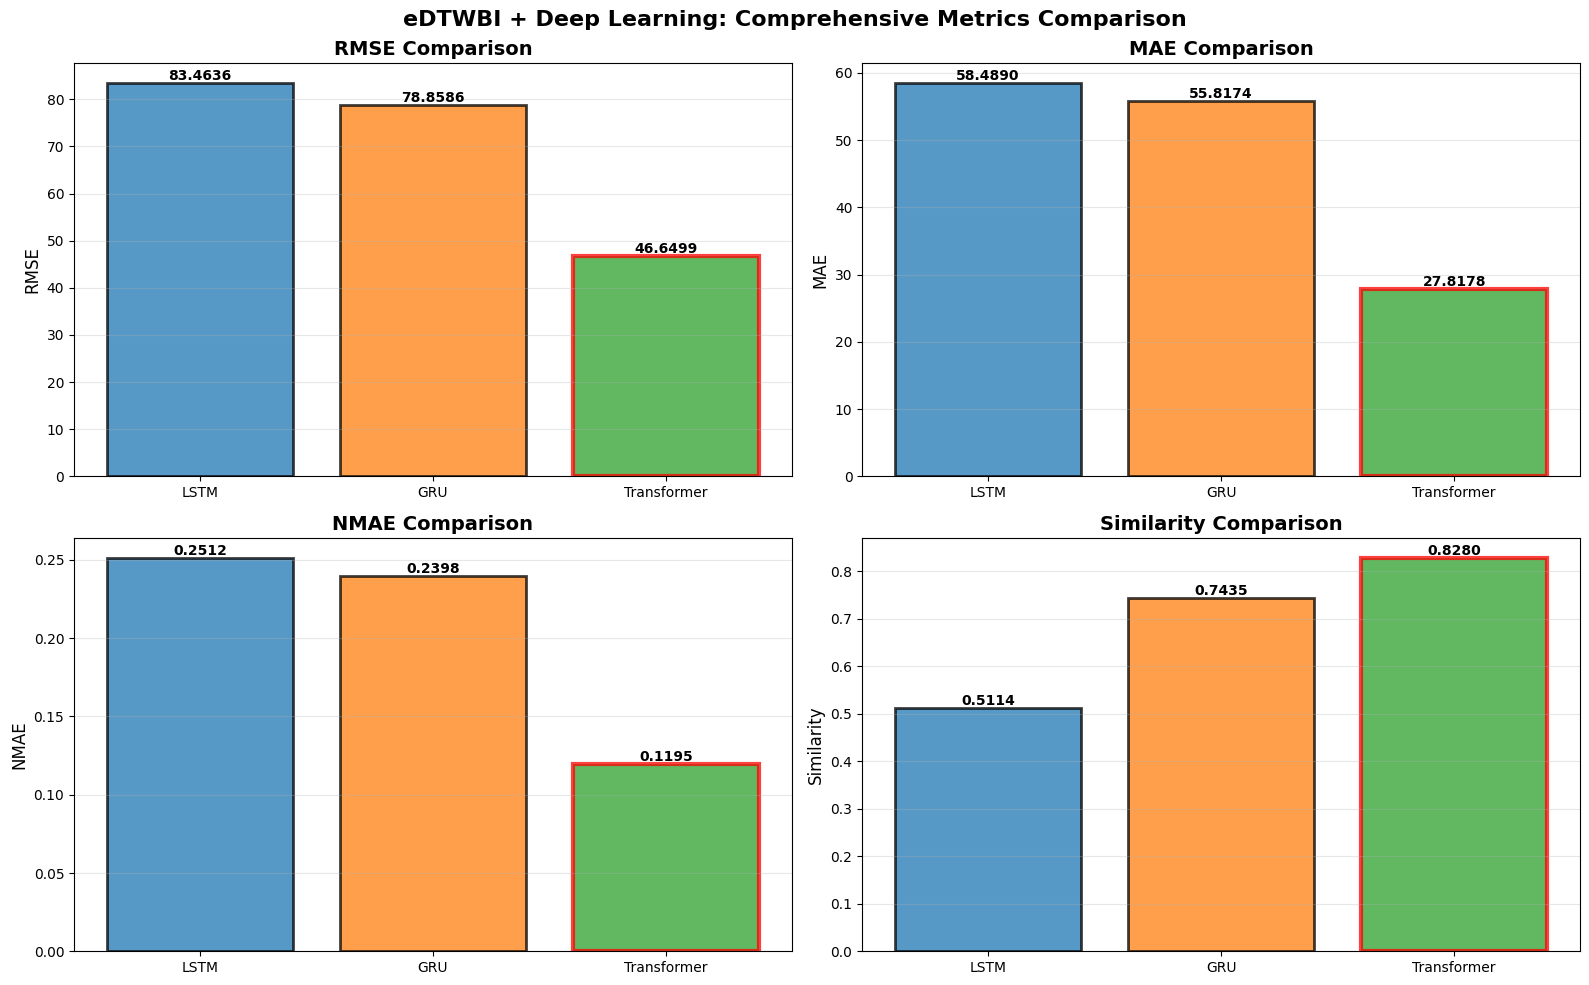

✓ Chart saved!


In [30]:
# ============================================================================
# CELL 10: METRICS COMPARISON VISUALIZATION
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

models = results_df_final['Model'].values
metrics = ['RMSE', 'MAE', 'NMAE', 'Similarity']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = results_df_final[metric].values
    
    bars = ax.bar(models, values, color=colors, alpha=0.75, 
                  edgecolor='black', linewidth=2)
    
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    for i, (bar, v) in enumerate(zip(bars, values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # Highlight best model
    if metric == 'Similarity':
        best_idx = values.argmax()
    else:
        best_idx = values.argmin()
    bars[best_idx].set_edgecolor('red')
    bars[best_idx].set_linewidth(3)

plt.suptitle('eDTWBI + Deep Learning: Comprehensive Metrics Comparison', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{CONFIG["output_path"]}/metrics_comparison_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart saved!")
